In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import requests
import folium
from math import radians, sin, cos, sqrt, atan2
from datetime import datetime, timedelta
import numpy as np
from folium.plugins import HeatMap
from scipy.spatial.distance import pdist, squareform
from folium.plugins import MarkerCluster
from IPython.display import display
import glob
import os

In [2]:
df = pd.read_csv('Toronto Bikeshare May2023 - Apr2024.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5336042 entries, 0 to 5336041
Data columns (total 28 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Start Time           object 
 1   Start Station Name   object 
 2   End Station Id       float64
 3   End Time             object 
 4   End Station Name     object 
 5   Bike Id              int64  
 6   User Type            object 
 7   lat_start            float64
 8   lon_start            float64
 9   lat_end              float64
 10  lon_end              float64
 11  Model                object 
 12  Trip Duration (min)  float64
 13  Hour                 int64  
 14  Day of Week          object 
 15  Month                object 
 16  Date                 object 
 17  Distance (km)        float64
 18  Speed (km/h)         float64
 19  Station Pair         object 
 20  Temperature          float64
 21  Dew Point            float64
 22  Relative Humidity    float64
 23  Precipitation        float64
 24

In [9]:
def create_complete_sorted_station_dataset(df):
    """
    Creates a complete dataset with all hours for each station, sorted by time.
    
    Parameters:
    df (pandas.DataFrame): Original bike trip dataset
    
    Returns:
    pandas.DataFrame: Complete dataset with all hours, sorted by time
    """
    # Get unique stations from Start Station Name
    stations = df['Start Station Name'].unique()
    
    # Create complete date range
    start_date = pd.to_datetime(df['Date']).min()
    end_date = pd.to_datetime(df['Date']).max()
    
    # Create all possible hour combinations for each station
    date_range = pd.date_range(start=start_date, end=end_date, freq='H')
    
    # Create a complete index for all stations and hours
    station_hours = []
    for date in date_range:
        for station in stations:
            station_hours.append({
                'Station_Name': station,
                'DateTime': date,
                'Date': date.date(),
                'Hour': date.hour
            })
    
    # Create complete dataset
    complete_df = pd.DataFrame(station_hours)
    
    # Process original data to get hourly counts
    df['DateTime'] = pd.to_datetime(df['Date']) + pd.to_timedelta(df['Hour'], unit='h')
    
    # Calculate outflows (trips starting from station)
    outflows = df.groupby(['Start Station Name', 'DateTime']).size().reset_index(name='Outflow_Count')
    outflows['lat'] = df.groupby(['Start Station Name', 'DateTime'])['lat_start'].first().values
    outflows['lon'] = df.groupby(['Start Station Name', 'DateTime'])['lon_start'].first().values
    
    # Calculate inflows (trips ending at station)
    inflows = df.groupby(['End Station Name', 'DateTime']).size().reset_index(name='Inflow_Count')
    
    # Merge outflows with complete dataset
    merged_df = pd.merge(complete_df, 
                        outflows.rename(columns={'Start Station Name': 'Station_Name'}),
                        on=['Station_Name', 'DateTime'],
                        how='left')
    
    # Merge inflows
    merged_df = pd.merge(merged_df,
                        inflows.rename(columns={'End Station Name': 'Station_Name'}),
                        on=['Station_Name', 'DateTime'],
                        how='left')
    
    # Fill NaN values
    merged_df['Outflow_Count'] = merged_df['Outflow_Count'].fillna(0)
    merged_df['Inflow_Count'] = merged_df['Inflow_Count'].fillna(0)
    
    # Get weather data
    weather_data = df.groupby('DateTime').agg({
        'Temperature': 'first',
        'Dew Point': 'first',
        'Relative Humidity': 'first',
        'Precipitation': 'first',
        'Wind Direction': 'first',
        'Wind Speed': 'first',
        'Pressure': 'first',
        'Cloud Cover': 'first'
    }).reset_index()
    
    # Merge weather data
    merged_df = pd.merge(merged_df, weather_data, on='DateTime', how='left')
    
    # Fill missing location data
    station_locations = df.groupby('Start Station Name').agg({
        'lat_start': 'first',
        'lon_start': 'first'
    }).reset_index()
    
    merged_df = pd.merge(
        merged_df,
        station_locations.rename(columns={
            'Start Station Name': 'Station_Name',
            'lat_start': 'Latitude',
            'lon_start': 'Longitude'
        }),
        on='Station_Name',
        how='left'
    )
    
    # Calculate Net Flow
    merged_df['Net_Flow'] = merged_df['Inflow_Count'] - merged_df['Outflow_Count']
    
    # Add activity status
    merged_df['Activity_Status'] = np.where(
        (merged_df['Inflow_Count'] > 0) | (merged_df['Outflow_Count'] > 0),
        'Active',
        'Not Active'
    )
    
    # Add time-based columns
    merged_df['Day_of_Week'] = merged_df['DateTime'].dt.day_name()
    merged_df['Month'] = merged_df['DateTime'].dt.month_name()
    
    # Sort by DateTime and then Station_Name
    merged_df = merged_df.sort_values(['DateTime', 'Station_Name'])
    
    # Fill weather data forward and backward within each hour
    weather_cols = ['Temperature', 'Dew Point', 'Relative Humidity', 'Precipitation', 
                   'Wind Direction', 'Wind Speed', 'Pressure', 'Cloud Cover']
    
    for col in weather_cols:
        merged_df[col] = merged_df.groupby('DateTime')[col].transform(
            lambda x: x.fillna(method='ffill').fillna(method='bfill')
        )
    
    # Final column order
    final_columns = [
        'DateTime',
        'Date',
        'Hour',
        'Station_Name',
        'Outflow_Count',
        'Inflow_Count',
        'Net_Flow',
        'Activity_Status',
        'Latitude',
        'Longitude',
        'Temperature',
        'Dew Point',
        'Relative Humidity',
        'Precipitation',
        'Wind Direction',
        'Wind Speed',
        'Pressure',
        'Cloud Cover',
        'Day_of_Week',
        'Month'
    ]
    
    merged_df = merged_df[final_columns]
    
    return merged_df

def verify_completeness(df):
    """
    Verifies the completeness of the dataset and shows time-based statistics
    """
    n_stations = df['Station_Name'].nunique()
    n_days = (df['Date'].max() - df['Date'].min()).days + 1
    expected_rows = n_stations * n_days * 24
    
    print("Dataset Coverage:")
    print("-----------------")
    print(f"Date Range: {df['Date'].min()} to {df['Date'].max()}")
    print(f"Number of stations: {n_stations}")
    print(f"Number of days: {n_days}")
    print(f"Expected number of rows: {expected_rows}")
    print(f"Actual number of rows: {len(df)}")
    print(f"Missing rows: {expected_rows - len(df)}")
    
    print("\nActivity Status Distribution:")
    print("--------------------------")
    activity_dist = df['Activity_Status'].value_counts()
    print(activity_dist)
    print(f"\nPercentage Active: {(activity_dist['Active'] / len(df) * 100):.2f}%")
    
    print("\nTime Distribution:")
    print("-----------------")
    print("\nBy Hour:")
    print(df.groupby('Hour')['Activity_Status'].value_counts().unstack(fill_value=0))
    
    print("\nBy Day of Week:")
    print(df.groupby('Day_of_Week')['Activity_Status'].value_counts().unstack(fill_value=0))


In [10]:
# Create the complete, sorted dataset
complete_sorted_df = create_complete_sorted_station_dataset(df)

# Verify the completeness and see time-based statistics
verify_completeness(complete_sorted_df)

#View the first few rows to verify sorting
print(complete_sorted_df[['DateTime', 'Station_Name', 'Activity_Status']].head(20))

C:\Users\user\AppData\Local\Temp\ipykernel_4536\942488193.py:121: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.fillna(method='ffill').fillna(method='bfill')


Dataset Coverage:
-----------------
Date Range: 2023-05-01 to 2024-04-30
Number of stations: 797
Number of days: 366
Expected number of rows: 7000848
Actual number of rows: 6982517
Missing rows: 18331

Activity Status Distribution:
--------------------------
Activity_Status
Not Active    4248157
Active        2734360
Name: count, dtype: int64

Percentage Active: 39.16%

Time Distribution:
-----------------

By Hour:
Activity_Status  Active  Not Active
Hour                               
0                 70545      221157
1                 50461      240444
2                 39253      251652
3                 24861      266044
4                 21979      268926
5                 41408      249497
6                 80795      210110
7                120413      170492
8                147409      143496
9                137663      153242
10               130403      160502
11               136984      153921
12               144812      146093
13               146559      144346
14  

In [11]:
complete_sorted_df.to_csv('new.csv', index=False)

In [12]:
df = pd.read_csv('new.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6982517 entries, 0 to 6982516
Data columns (total 20 columns):
 #   Column             Dtype  
---  ------             -----  
 0   DateTime           object 
 1   Date               object 
 2   Hour               int64  
 3   Station_Name       object 
 4   Outflow_Count      float64
 5   Inflow_Count       float64
 6   Net_Flow           float64
 7   Activity_Status    object 
 8   Latitude           float64
 9   Longitude          float64
 10  Temperature        float64
 11  Dew Point          float64
 12  Relative Humidity  float64
 13  Precipitation      float64
 14  Wind Direction     float64
 15  Wind Speed         float64
 16  Pressure           float64
 17  Cloud Cover        float64
 18  Day_of_Week        object 
 19  Month              object 
dtypes: float64(13), int64(1), object(6)
memory usage: 1.0+ GB


In [15]:
df.head(30)

,DateTime,Date,Hour,Station_Name,Outflow_Count,Inflow_Count,Net_Flow,Activity_Status,Latitude,Longitude,Temperature,Dew Point,Relative Humidity,Precipitation,Wind Direction,Wind Speed,Pressure,Cloud Cover,Day_of_Week,Month
0,2023-05-01 00:00:00,2023-05-01,0,1 Market St - SMART,0.0,0.0,0.0,Not Active,43.646993,-79.370666,9.8,7.0,83.0,0.2,300.0,22.3,993.4,7.0,Monday,May
1,2023-05-01 00:00:00,2023-05-01,0,101 Cedarvale Ave,0.0,0.0,0.0,Not Active,43.686868,-79.311094,9.8,7.0,83.0,0.2,300.0,22.3,993.4,7.0,Monday,May
2,2023-05-01 00:00:00,2023-05-01,0,11 Spadina Rd,0.0,0.0,0.0,Not Active,43.667725,-79.404137,9.8,7.0,83.0,0.2,300.0,22.3,993.4,7.0,Monday,May
3,2023-05-01 00:00:00,2023-05-01,0,111 Bond St (North of Dundas St E) - SMART,0.0,0.0,0.0,Not Active,43.656927,-79.378497,9.8,7.0,83.0,0.2,300.0,22.3,993.4,7.0,Monday,May
4,2023-05-01 00:00:00,2023-05-01,0,111 Broadview Ave,0.0,0.0,0.0,Not Active,43.659348,-79.349937,9.8,7.0,83.0,0.2,300.0,22.3,993.4,7.0,Monday,May
5,2023-05-01 00:00:00,2023-05-01,0,12 Harbour St,0.0,0.0,0.0,Not Active,43.642564,-79.376200,9.8,7.0,83.0,0.2,300.0,22.3,993.4,7.0,Monday,May
6,2023-05-01 00:00:00,2023-05-01,0,128 Sterling Ave - SMART,0.0,0.0,0.0,Not Active,43.654004,-79.444792,9.8,7.0,83.0,0.2,300.0,22.3,993.4,7.0,Monday,May
7,2023-05-01 00:00:00,2023-05-01,0,1303 Yonge St - SMART,0.0,0.0,0.0,Not Active,43.684618,-79.392459,9.8,7.0,83.0,0.2,300.0,22.3,993.4,7.0,Monday,May
8,2023-05-01 00:00:00,2023-05-01,0,135 Queens Wharf - SMART,0.0,0.0,0.0,Not Active,43.639971,-79.399404,9.8,7.0,83.0,0.2,300.0,22.3,993.4,7.0,Monday,May
9,2023-05-01 00:00:00,2023-05-01,0,15 Price St,0.0,0.0,0.0,Not Active,43.679948,-79.389948,9.8,7.0,83.0,0.2,300.0,22.3,993.4,7.0,Monday,May


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def analyze_bikeshare_data(df):
    """
    Perform exploratory data analysis on bike share data
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame with bike share data
    """
    
    # 1. Basic Data Info
    print("\n=== Basic Information ===")
    print("\nDataset Shape:", df.shape)
    print("\nNumber of Unique Stations:", df['Station_Name'].nunique())
    print("\nDate Range:", df['DateTime'].min(), "to", df['DateTime'].max())
    
    # 2. Convert DateTime if not already datetime
    if not pd.api.types.is_datetime64_any_dtype(df['DateTime']):
        df['DateTime'] = pd.to_datetime(df['DateTime'])
    
    # 3. Temporal Analysis
    
    # Hourly patterns by day type (weekday vs weekend)
    df['is_weekend'] = df['Day_of_Week'].isin(['Saturday', 'Sunday'])
    hourly_patterns = df.groupby(['Hour', 'is_weekend'])[['Inflow_Count', 'Outflow_Count']].mean().reset_index()
    
    fig, ax = plt.subplots(figsize=(15, 6))
    for flow_type in ['Inflow_Count', 'Outflow_Count']:
        for is_weekend in [True, False]:
            data = hourly_patterns[hourly_patterns['is_weekend'] == is_weekend]
            label = f"{'Weekend' if is_weekend else 'Weekday'} {flow_type.split('_')[0]}"
            ax.plot(data['Hour'], data[flow_type], label=label, marker='o')
    
    plt.title('Average Hourly Flow Patterns: Weekday vs Weekend')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Count')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Monthly patterns
    monthly_traffic = df.groupby('Month')[['Inflow_Count', 'Outflow_Count']].mean()
    
    plt.figure(figsize=(12, 6))
    monthly_traffic.plot(kind='line', marker='o')
    plt.title('Average Monthly Traffic Patterns')
    plt.xlabel('Month')
    plt.ylabel('Average Count')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()
    
    # 4. Station Analysis
    station_metrics = df.groupby('Station_Name').agg({
        'Inflow_Count': ['mean', 'sum', 'std'],
        'Outflow_Count': ['mean', 'sum', 'std'],
        'Net_Flow': ['mean', 'sum']
    }).round(2)
    
    # Identify stations with significant imbalances
    station_metrics['imbalance_ratio'] = (
        station_metrics[('Inflow_Count', 'sum')] / 
        station_metrics[('Outflow_Count', 'sum')]
    ).round(2)
    
    print("\n=== Top 10 Busiest Stations ===")
    print(station_metrics.sort_values(('Inflow_Count', 'sum'), ascending=False).head(10))
    
    print("\n=== Most Imbalanced Stations ===")
    print(station_metrics.sort_values('imbalance_ratio', ascending=False).head(10))
    
    # 5. Geographic Distribution
    # Calculate average daily traffic for each station
    station_avg_traffic = df.groupby(['Station_Name', 'Latitude', 'Longitude'])[
        ['Inflow_Count', 'Outflow_Count']
    ].mean().reset_index()
    
    plt.figure(figsize=(15, 10))
    plt.scatter(station_avg_traffic['Longitude'], 
                station_avg_traffic['Latitude'],
                c=station_avg_traffic['Inflow_Count'],
                s=100,
                alpha=0.6,
                cmap='YlOrRd')
    plt.colorbar(label='Average Daily Inflow')
    plt.title('Geographic Distribution of Stations with Traffic Heat Map')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
    
    # 6. Weather Impact Analysis
    
    # Temperature impact
    temp_bins = [-np.inf, 0, 10, 20, 30, np.inf]
    temp_labels = ['<0°C', '0-10°C', '10-20°C', '20-30°C', '>30°C']
    df['temp_category'] = pd.cut(df['Temperature'], 
                                bins=temp_bins, 
                                labels=temp_labels)
    
    weather_impact = df.groupby('temp_category')[['Inflow_Count', 'Outflow_Count']].mean()
    
    plt.figure(figsize=(12, 6))
    weather_impact.plot(kind='bar')
    plt.title('Average Traffic by Temperature Range')
    plt.xlabel('Temperature Range')
    plt.ylabel('Average Count')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Rain impact
    rain_impact = df.groupby(df['Precipitation'] > 0)[
        ['Inflow_Count', 'Outflow_Count']
    ].mean()
    
    print("\n=== Impact of Rain on Ridership ===")
    print(rain_impact)
    
    # 7. Peak Hour Analysis
    peak_hours = df.groupby('Hour')[['Inflow_Count', 'Outflow_Count']].agg([
        'mean', 'max', 'std'
    ]).round(2)
    
    print("\n=== Peak Hour Statistics ===")
    print(peak_hours.sort_values(('Inflow_Count', 'mean'), ascending=False).head())
    
    # 8. System-wide Daily Patterns
    daily_total = df.groupby('Date')[['Inflow_Count', 'Outflow_Count']].sum()
    
    plt.figure(figsize=(15, 6))
    daily_total.plot(alpha=0.5)
    daily_total.rolling(7).mean().plot(linewidth=2)
    plt.title('Daily Total Traffic with 7-day Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Total Count')
    plt.legend(['Daily Inflow', 'Daily Outflow', '7-day Avg Inflow', '7-day Avg Outflow'])
    plt.grid(True)
    plt.show()
    
    # 9. Calculate key statistics
    stats = {
        'total_trips': df['Inflow_Count'].sum(),
        'avg_daily_trips': df.groupby('Date')['Inflow_Count'].sum().mean(),
        'peak_day': df.groupby('Date')['Inflow_Count'].sum().idxmax(),
        'peak_hour': df.groupby('Hour')['Inflow_Count'].mean().idxmax(),
        'most_used_station': station_metrics[('Inflow_Count', 'sum')].idxmax(),
        'weather_correlation': df[['Inflow_Count', 'Temperature', 'Precipitation', 'Wind Speed']].corr()['Inflow_Count']
    }
    
    print("\n=== Key Statistics ===")
    for key, value in stats.items():
        print(f"{key}: {value}")
    
    return {
        'station_metrics': station_metrics,
        'hourly_patterns': hourly_patterns,
        'monthly_traffic': monthly_traffic,
        'weather_impact': weather_impact,
        'peak_hours': peak_hours,
        'daily_total': daily_total,
        'stats': stats
    }



=== Basic Information ===

Dataset Shape: (6982517, 20)

Number of Unique Stations: 797

Date Range: 2023-05-01 00:00:00 to 2024-04-30 00:00:00


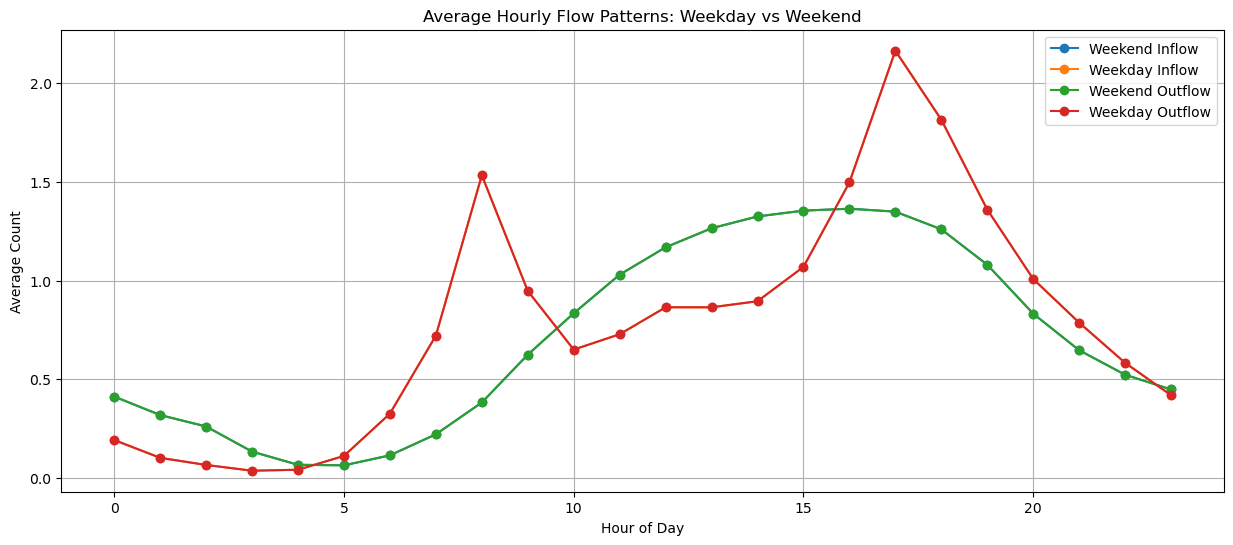

<Figure size 1200x600 with 0 Axes>

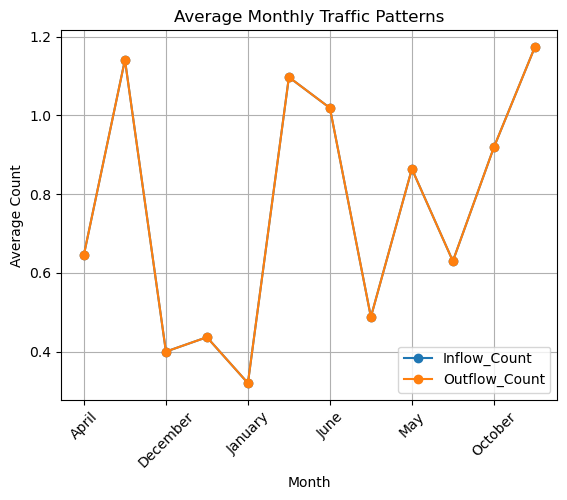


=== Top 10 Busiest Stations ===
                                 Inflow_Count                 Outflow_Count  \
                                         mean      sum    std          mean   
Station_Name                                                                  
King St W / Bay St (West Side)           6.27  54924.0  19.38          2.91   
Union Station                            6.20  54320.0   6.63          4.52   
York St / Queens Quay W                  5.68  49726.0   7.39          4.47   
Bay St / College St (East Side)          4.95  43375.0   4.94          4.90   
King St W / Brant St                     4.87  42695.0   5.67          4.84   
Queen St W / John St                     4.11  35997.0   4.47          3.84   
Simcoe St / Queen St W                   4.06  35600.0   5.03          3.55   
Nelson St / Duncan St                    3.93  34392.0   4.79          3.11   
Dundas St W / Yonge St                   3.87  33936.0   4.49          3.71   
College Park - Yong

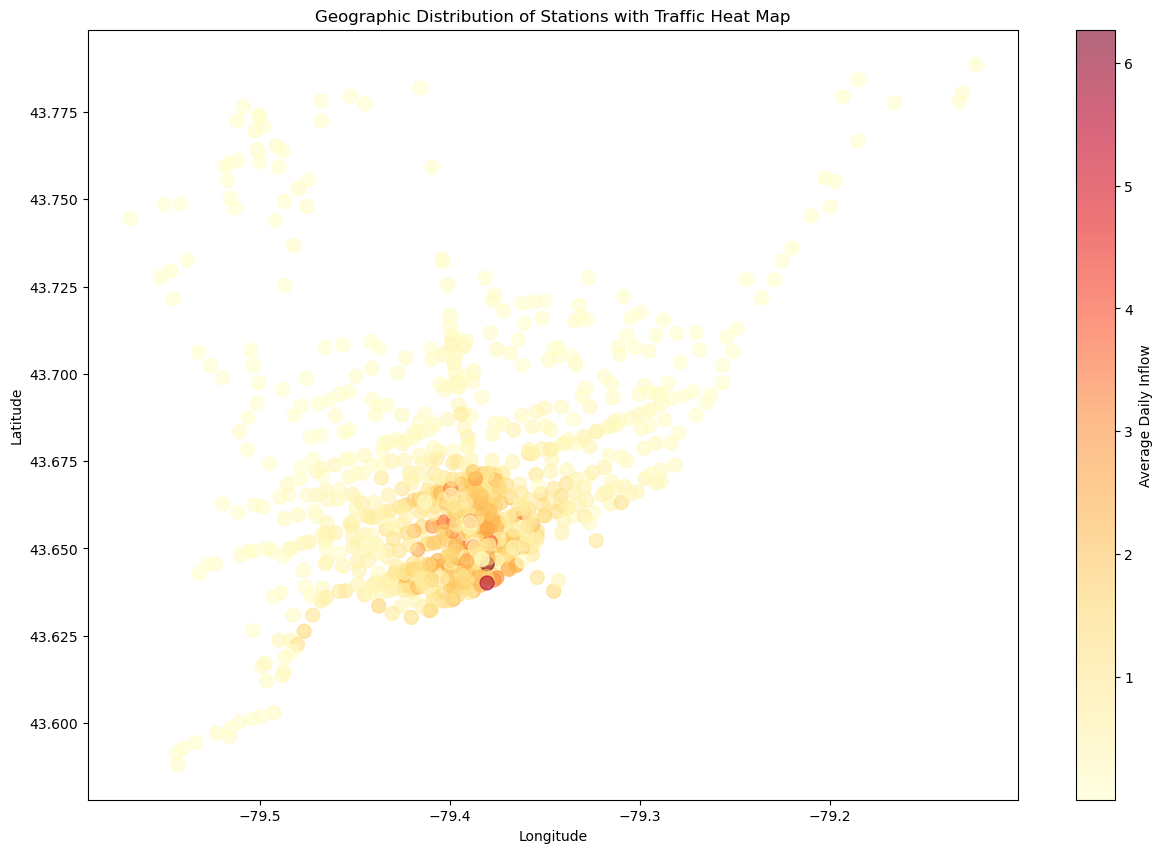

C:\Users\user\AppData\Local\Temp\ipykernel_4536\2413749585.py:104: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weather_impact = df.groupby('temp_category')[['Inflow_Count', 'Outflow_Count']].mean()


<Figure size 1200x600 with 0 Axes>

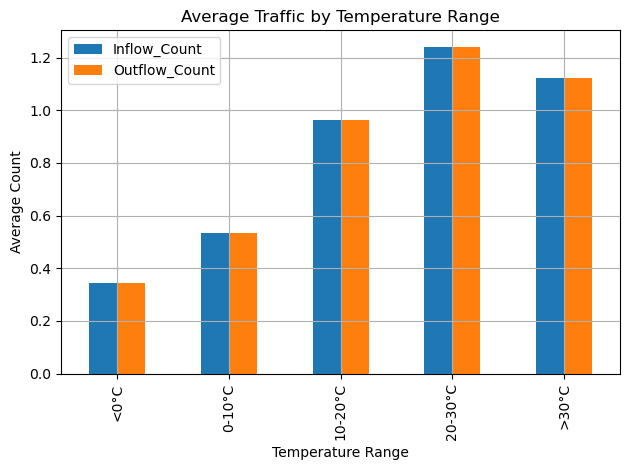


=== Impact of Rain on Ridership ===
               Inflow_Count  Outflow_Count
Precipitation                             
False              0.783868       0.783868
True               0.606120       0.606120

=== Peak Hour Statistics ===
     Inflow_Count              Outflow_Count            
             mean    max   std          mean   max   std
Hour                                                    
17           1.93   81.0  3.19          1.93  97.0  3.48
18           1.66   86.0  2.86          1.66  68.0  2.91
16           1.46   59.0  2.48          1.46  54.0  2.57
19           1.28  105.0  2.41          1.28  47.0  2.36
8            1.21  221.0  4.13          1.21  31.0  2.27


<Figure size 1500x600 with 0 Axes>

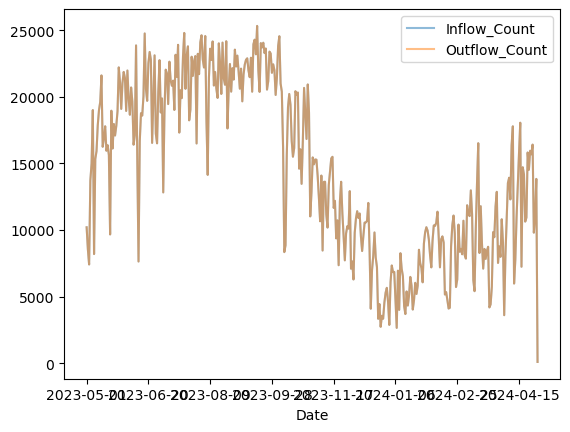

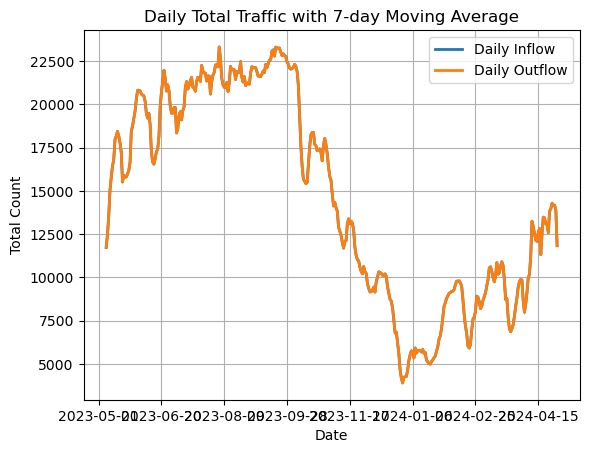


=== Key Statistics ===
total_trips: 5319946.0
avg_daily_trips: 14535.371584699453
peak_day: 2023-09-16
peak_hour: 17
most_used_station: King St W / Bay St (West Side)
weather_correlation: Inflow_Count     1.000000
Temperature      0.159762
Precipitation   -0.017677
Wind Speed      -0.039144
Name: Inflow_Count, dtype: float64


In [17]:
results = analyze_bikeshare_data(df)